# RNN

## Imports :

In [1]:
import string
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from pathlib import Path
import math

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Data :

In [2]:
df = pd.read_csv("archive/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Data cleaning

In [3]:
# Changement des labels en 0 et 1
def label_replacement(label):
    
    if label == 4:
        return 1
    else:
        return label
    
df['polarity']=df['polarity'].apply(label_replacement)
df.groupby('polarity').count()

,id,date,query,user,text
polarity,,,,,
0,800000,800000,800000,800000,800000
1,800000,800000,800000,800000,800000


In [4]:
# Suppression des colonnes inutiles 
df = df.drop(columns=['id', 'date', 'query', 'user'])

In [5]:
# Suppression des doublons 
df=df.drop_duplicates(keep='last')

In [6]:
# Supression des characters innutiles 
df['text']=df['text'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",regex=True)
df.head()

,polarity,text
0,0,Awww that s a bummer You shoulda got ...
1,0,is upset that he can t update his Facebook by ...
2,0,I dived many times for the ball Managed to ...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why a...


In [7]:
# Stopwords
stop_words=stopwords.words('english')
stop_words.extend(['user','amp'])

In [8]:
# Lemmatizer
word_lemmatizer = WordNetLemmatizer()

In [9]:
# Fonction de netoyage 
def clean_tweets(text):
    nopunc=[i for i in text if i not in string.punctuation]
    nopunc=''.join(nopunc)
    lowered = [i.lower() for i in nopunc.split() if i.lower() not in stop_words]
    lemmatized = [word_lemmatizer.lemmatize(w) for w in lowered ]
    lemmatized = ' '.join(lemmatized)
    return lemmatized

In [24]:
# Netoyage des tweets et nouvelle colonne length 
df['clean']=df['text'].apply(clean_tweets)
df['length']=df['clean'].apply(len)

## Visualisation data

In [25]:
#visualisation dataframe
df

,polarity,text,clean,length
0,0,Awww that s a bummer You shoulda got ...,awww bummer shoulda got david carr third day,44
1,0,is upset that he can t update his Facebook by ...,upset update facebook texting might cry result...,69
2,0,I dived many times for the ball Managed to ...,dived many time ball managed save 50 rest go b...,50
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire,31
4,0,no it s not behaving at all i m mad why a...,behaving mad see,16
...,...,...,...,...
1599995,1,Just woke up Having no school is the best fee...,woke school best feeling ever,29
1599996,1,TheWDB com Very cool to hear old Walt interv...,thewdb com cool hear old walt interview,39
1599997,1,Are you ready for your MoJo Makeover Ask me f...,ready mojo makeover ask detail,30
1599998,1,Happy 38th Birthday to my boo of alll time ...,happy 38th birthday boo alll time tupac amaru ...,52


 Average length of review in training dataset 41.803254549025034
 Std Deviation  of review in training dataset 23.497097612068


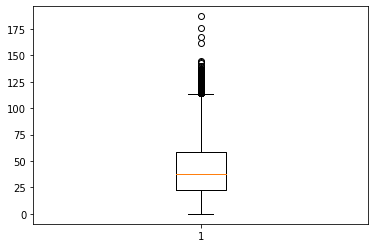

<AxesSubplot:ylabel='Frequency'>

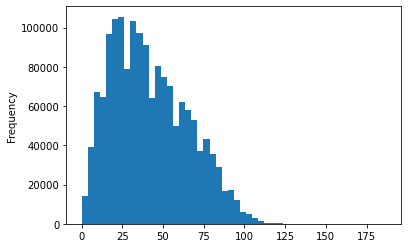

In [26]:
# Visualisation data pour choisir le padding 
text_len = [len(df.iat[i,2]) for i in range(len(df))]
print(" Average length of review in training dataset", np.mean(text_len))
print(" Std Deviation  of review in training dataset", np.std(text_len))
plt.boxplot(text_len)
plt.show()

df['length'].plot(bins=50,kind='hist')

## Preparation data pour word Embeding 

In [13]:
# Separation entre données de training et données de test
X_train, X_test, y_train, y_test = train_test_split(df.clean ,df.polarity, test_size=0.1, random_state=36)

In [14]:
print("Nombre de tweet pour train : ", len(X_train))
print("Nombre de tweet pour test : ", len(X_test))

Nombre de tweet pour train :  1425321
Nombre de tweet pour test :  158370


In [16]:
NB_WORDS = 10000  # Nombre de mots dans le dictionnaire 
# Tokanize cleaned text
tk = Tokenizer(num_words=NB_WORDS,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', split=" ")
tk.fit_on_texts(X_train)

In [17]:
# Transformation des tweets en sequence d'entiers
X_train = tk.texts_to_sequences(X_train)
X_test = tk.texts_to_sequences(X_test)

## Padding

In [28]:
#padding
max_words = 200
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

In [112]:
# exemple padding à 200 mots
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [113]:
# tweet à l'origine 
tk.sequences_to_texts([X_train[1]])

['try static app got yet figure supposed work']

## Design model 

In [36]:
embedding_size=32
vocabulary_size = 10000
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# compilation model 
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [38]:
# parametres train model
batch_size = 64
num_epochs = 3

In [39]:
# Fitting the model 
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
22270/22270 [==============================] - 2010s 90ms/step - loss: 0.4871 - accuracy: 0.7615 - val_loss: 0.4358 - val_accuracy: 0.7969
Epoch 2/3
22270/22270 [==============================] - 2928s 132ms/step - loss: 0.4459 - accuracy: 0.7886 - val_loss: 0.4669 - val_accuracy: 0.7344
Epoch 3/3
22270/22270 [==============================] - 2013s 90ms/step - loss: 0.4305 - accuracy: 0.7969 - val_loss: 0.4250 - val_accuracy: 0.7500


In [40]:
# Evaluation du model 
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.7887541651725769


## Pipeline, *test new tweet* 

In [104]:
def pipeline(tweet):
    tweet = clean_tweets(tweet)
    #print(tweet)
    tweet = tk.texts_to_sequences([tweet])
    #print(tweet)
    tweet = pad_sequences (tweet, maxlen=max_words)
    #print(tweet)
    polarity = model.predict([tweet])
    if polarity>=0.5 :
        polarity = 'positive'
    else :
        polarity = 'negative'
    return polarity

In [105]:
# Positive tweet test :
pipeline('I realy like dogs, they are amazing')

'positive'

In [108]:
# Negative tweet test :
pipeline('The movie was realy bad! gosh ')

'negative'

## API YELP

In [116]:
import requests
r = requests.get('https://www.yelp.com/biz/tesla-san-francisco?osq=Tesla+Dealership')

In [117]:
print(r.status_code)

200


In [119]:
from bs4 import BeautifulSoup

In [120]:
soup = BeautifulSoup(r.text, 'html.parser')

In [127]:
results = soup.findAll(class_='review__373c0__13kpL')

In [128]:
reviews = []
for result in results:
    reviews.append(result.find('p').text)

In [129]:
dfYelp = pd.DataFrame(np.array(reviews), columns=['review'])

In [130]:
dfYelp

,review
0,Today was delivery day and we were pretty exci...
1,I had an issue with the undercarriage cover. T...
2,Horrible customer service:1) Placed order via ...
3,DREADFUL CUSTOMER SERVICE AND EXPERIENCE My mo...
4,The service center here is TERRIBLE. I had a t...
5,I recently brought a brand new Tesla to fix so...
6,"Unfortunately, as a recent new Tesla owner, I ..."
7,Great experience overall. Took a little long f...
8,I bought a Model X with a warranty from Tesla ...
9,Don't take vehicle delivery at this SF service...


In [131]:
dfYelp['polarity']=dfYelp['review'].apply(pipeline)

In [132]:
dfYelp

,review,polarity
0,Today was delivery day and we were pretty exci...,positive
1,I had an issue with the undercarriage cover. T...,positive
2,Horrible customer service:1) Placed order via ...,negative
3,DREADFUL CUSTOMER SERVICE AND EXPERIENCE My mo...,negative
4,The service center here is TERRIBLE. I had a t...,negative
5,I recently brought a brand new Tesla to fix so...,negative
6,"Unfortunately, as a recent new Tesla owner, I ...",negative
7,Great experience overall. Took a little long f...,positive
8,I bought a Model X with a warranty from Tesla ...,negative
9,Don't take vehicle delivery at this SF service...,negative
